In [1]:
import pandas as pd
import numpy as np
import time

%matplotlib inline
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set_style("darkgrid")
#import os
#os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin'
from keras.models import Model
from keras.layers import Input, LSTM, Dense, LSTMCell, RNN, Bidirectional, concatenate
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
#import pydot_ng
#import pydotplus
#from keras.utils.vis_utils import plot_model


Using TensorFlow backend.


In [2]:
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF

config = tf.ConfigProto()  
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
sess = tf.Session(config=config)

# 设置session
KTF.set_session(sess)


In [3]:
data = pd.read_csv("E:/python_code/时间序列预测/23xin_swat_1min.csv",index_col=0, parse_dates=[0])
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6840 entries, 2015-12-23 16:00:00 to 2015-12-28 09:59:00
Data columns (total 25 columns):
FIT101     6840 non-null float64
LIT101     6840 non-null float64
AIT201     6840 non-null float64
AIT202     6840 non-null float64
AIT203     6840 non-null float64
FIT201     6840 non-null float64
DPIT301    6840 non-null float64
FIT301     6840 non-null float64
LIT301     6840 non-null float64
AIT401     6840 non-null float64
AIT402     6840 non-null float64
FIT401     6840 non-null float64
LIT401     6840 non-null float64
AIT501     6840 non-null float64
AIT502     6840 non-null float64
AIT503     6840 non-null float64
AIT504     6840 non-null float64
FIT501     6840 non-null float64
FIT502     6840 non-null float64
FIT503     6840 non-null float64
FIT504     6840 non-null float64
PIT501     6840 non-null float64
PIT502     6840 non-null float64
PIT503     6840 non-null float64
FIT601     6840 non-null float64
dtypes: float64(25)
memory usage

In [4]:
data.head()

,FIT101,LIT101,AIT201,AIT202,AIT203,FIT201,DPIT301,FIT301,LIT301,AIT401,...,AIT503,AIT504,FIT501,FIT502,FIT503,FIT504,PIT501,PIT502,PIT503,FIT601
Timestamp,,,,,,,,,,,,,,,,,,,,,
2015-12-23 16:00:00,0.0,680.3288,254.0374,8.349654,334.1194,2.459104,19.77399,2.216058,804.0006,148.808,...,256.0562,11.18944,1.719815,1.281030,0.739878,0.308426,252.0347,1.569859,191.5054,0.000128
2015-12-23 16:01:00,0.0,649.9865,254.0054,8.352218,333.5555,2.452312,19.79960,2.214137,805.2022,148.808,...,256.0562,11.18944,1.721866,1.261432,0.739750,0.308362,252.2270,1.569859,191.6175,0.000128
2015-12-23 16:02:00,0.0,622.9020,254.0054,8.351577,333.5299,2.451799,19.69076,2.218493,809.5681,148.808,...,255.7677,11.11254,1.719815,1.281286,0.738341,0.308426,251.9546,1.617916,191.3772,0.000128
2015-12-23 16:03:00,0.0,594.7186,254.0054,8.353179,333.2479,2.452696,19.79000,2.216699,812.6122,148.808,...,255.8959,11.11254,1.718534,1.254515,0.739750,0.310540,251.5861,1.505783,190.9446,0.000128
2015-12-23 16:04:00,0.0,566.1033,254.0054,8.352859,333.1710,2.451158,19.80601,2.215162,814.6549,148.808,...,255.7677,11.07408,1.720200,1.281927,0.738341,0.308426,252.0668,1.569859,191.4894,0.000128


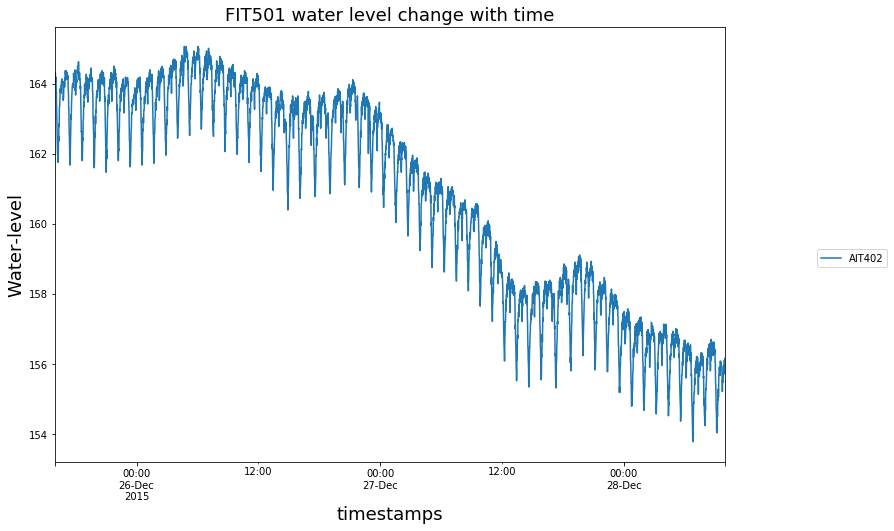

In [5]:
data = data['AIT402']
data=data.loc['2015-12-25 16:00:00':].resample('T').mean()
seq = data
#print(seq)
seq.plot(figsize=(12,8))
plt.legend(bbox_to_anchor=(1.25, 0.5))
plt.title("FIT501 water level change with time", fontsize = 18)
plt.xlabel("timestamps", fontsize = 18)
plt.ylabel("Water-level", fontsize = 18)
plt.show()

In [6]:
scaler = MinMaxScaler(feature_range=(-1,1))

X =scaler.fit_transform(seq.values.reshape(-1,1))
#x=scaler.inverse_transform(X).flatten().tolist()
#print(type(x))
#print(x)
print(len(X))

3960


In [7]:
x_train = X[:-400]
y = X[-400:]
print(len(x_train))
print(len(y))

3560
400


In [8]:
input_seq_len = 300
output_seq_len = 75
n_in_features = 1
n_out_features = 1
batch_size = 128
#[60] 单向 后800个为测试集
#25日16点以后

In [9]:
def generate_train_sequences(x):
    
    total_start_points = len(x) - input_seq_len - output_seq_len
    start_x_idx = np.random.choice(range(total_start_points), total_start_points, replace = False)
    
    input_batch_idxs = [(range(i, i+input_seq_len)) for i in start_x_idx]
    input_seq = np.take(x, input_batch_idxs, axis = 0)
    
    output_batch_idxs = [(range(i+input_seq_len, i+input_seq_len+output_seq_len)) for i in start_x_idx]
    output_seq = np.take(x, output_batch_idxs, axis = 0)
    
    input_seq =(input_seq.reshape(input_seq.shape[0],input_seq.shape[1],n_in_features))
    output_seq=(output_seq.reshape(output_seq.shape[0],output_seq.shape[1],n_out_features))
    
    return input_seq, output_seq

In [10]:
def create_model(layers, bidirectional=False):
    
    n_layers = len(layers)
    
    ## Encoder
    encoder_inputs = Input(shape=(None, n_in_features))
    lstm_cells = [LSTMCell(hidden_dim) for hidden_dim in layers]
    if bidirectional:
        encoder = Bidirectional(RNN(lstm_cells, return_state=True))
        encoder_outputs_and_states = encoder(encoder_inputs)
        bi_encoder_states = encoder_outputs_and_states[1:]
        encoder_states = []
        for i in range(int(len(bi_encoder_states)/2)):
            temp = concatenate([bi_encoder_states[i],bi_encoder_states[2*n_layers + i]], axis=-1)
            encoder_states.append(temp)
    else:  
        encoder = RNN(lstm_cells, return_state=True)
        encoder_outputs_and_states = encoder(encoder_inputs)
        encoder_states = encoder_outputs_and_states[1:]
    
    ## Decoder
    decoder_inputs = Input(shape=(None, n_out_features))
    if bidirectional:
        decoder_cells = [LSTMCell(hidden_dim*2) for hidden_dim in layers]
    else:
        decoder_cells = [LSTMCell(hidden_dim) for hidden_dim in layers]
        
    decoder_lstm = RNN(decoder_cells, return_sequences=True, return_state=True)

    decoder_outputs_and_states = decoder_lstm(decoder_inputs,
                                          initial_state=encoder_states)
    decoder_outputs = decoder_outputs_and_states[0]

    decoder_dense = Dense(n_out_features) 
    decoder_outputs = decoder_dense(decoder_outputs)
    
    model = Model([encoder_inputs,decoder_inputs], decoder_outputs)
    return model

In [11]:
def run_model(model,batches,epochs,batch_size):

    for _ in range(batches):

        input_seq, output_seq = generate_train_sequences(x_train)

        encoder_input_data = input_seq
        decoder_target_data = output_seq
        decoder_input_data = np.zeros(decoder_target_data.shape)

        history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                             batch_size=batch_size,
                             epochs=epochs,
                             validation_split=0.2, 
                             shuffle=False)
                           
        total_loss.append(history.history['loss'])
        total_val_loss.append(history.history['val_loss'])

In [12]:
model2_bi = create_model([35,35,35,35],bidirectional=True)
model2_bi.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 70), (None,  70000       input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 1)      0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 70)           0           bidirectional_1[0][1]            
                                     

In [13]:
total_loss = []
total_val_loss = []
model2_bi.compile(Adam(), loss = 'mean_squared_error')

In [14]:
start_time = time.time()
run_model(model2_bi,batches=1, epochs=50, batch_size=batch_size)
end_time = time.time()

Instructions for updating:
Use tf.cast instead.
Train on 2548 samples, validate on 637 samples
Epoch 1/50
2548/2548 [==============================] - 61s 24ms/step - loss: 0.1901 - val_loss: 0.0893
Epoch 2/50
2548/2548 [==============================] - 53s 21ms/step - loss: 0.0443 - val_loss: 0.0310
Epoch 3/50
2548/2548 [==============================] - 53s 21ms/step - loss: 0.0262 - val_loss: 0.0247
Epoch 4/50
2548/2548 [==============================] - 53s 21ms/step - loss: 0.0233 - val_loss: 0.0231
Epoch 5/50
2548/2548 [==============================] - 53s 21ms/step - loss: 0.0219 - val_loss: 0.0226
Epoch 6/50
2548/2548 [==============================] - 53s 21ms/step - loss: 0.0212 - val_loss: 0.0194
Epoch 7/50
2548/2548 [==============================] - 53s 21ms/step - loss: 0.0193 - val_loss: 0.0185
Epoch 8/50
2548/2548 [==============================] - 53s 21ms/step - loss: 0.0187 - val_loss: 0.0198
Epoch 9/50
2548/2548 [==============================] - 53s 21ms/step - l

In [15]:
run_time = (end_time - start_time)/50
run_time

54.17956516265869

In [16]:
def plot_loss(train_loss,val_loss):
    plt.figure(figsize=(12,7))
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Sqquared Error Loss')
    plt.title('Loss Over Time')
    plt.legend(['Train','Valid'])
    plt.show()

In [17]:
total_loss = [j for i in total_loss for j in i]
total_val_loss = [j for i in total_val_loss for j in i]

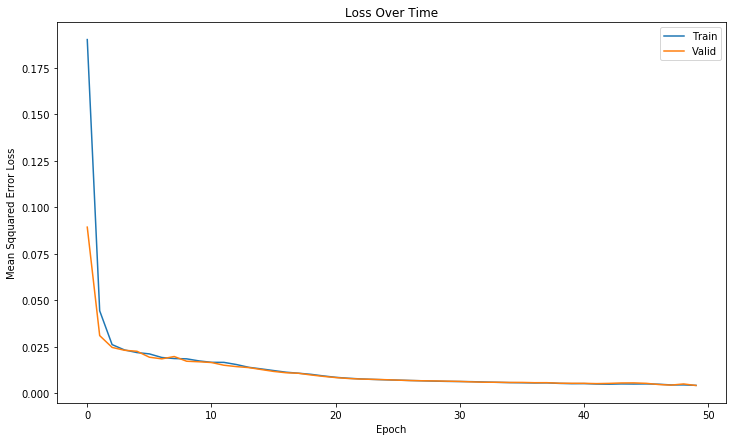

In [18]:
plot_loss(total_loss,total_val_loss)
#plt.savefig('model-png/bi_dir2_loss.png')

In [19]:
i=0
x_total_train=x_train
pred_total_value=np.empty((0,1), float)
output_total_seq_test=np.empty((0,1), float)
while i<5:

    input_seq_test = x_total_train[-input_seq_len:].reshape((1,input_seq_len,1))
    output_seq_test = y[output_seq_len*i:output_seq_len+output_seq_len*i]#2维0.xxx
    output_total_seq_test=np.vstack([output_total_seq_test,scaler.inverse_transform(output_seq_test)])#真实总量

    decoder_input_test = np.zeros((1,output_seq_len,1))
    pred1 = model2_bi.predict([input_seq_test,decoder_input_test])#3维0.xxx
    pred_values1 = scaler.inverse_transform(pred1.reshape(-1,1))#2维596.xxx
    pred_total_value=np.vstack([pred_total_value,pred_values1])#预测总量
                          
    output_seq_test1 = scaler.inverse_transform(output_seq_test)#2维600.xxx  2维0.xxx转2维600.xxx

    x_total_train=np.vstack([x_total_train,pred1.reshape(-1,1)])
    i=i+1

MAE score: 0.54 MAE
MSE score: 0.65 MSE
RMSE score: 0.81 RMSE
MAPE score: 0.35 MAPE
SMAPE score: 0.35 SMAPE
(375, 1)


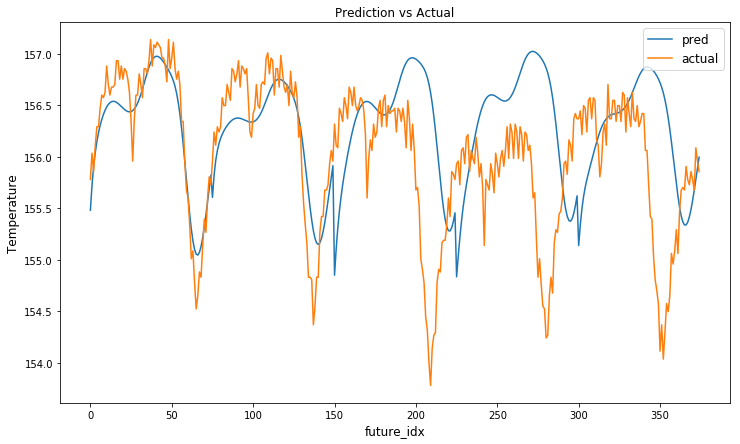

In [20]:
from sklearn import metrics
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
def smape(y_true, y_pred):
    return 2.0 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) * 100

MAE=metrics.mean_absolute_error(output_total_seq_test, pred_total_value)
print('MAE score: %.2f MAE' % (MAE))
MSE=metrics.mean_squared_error(output_total_seq_test, pred_total_value)
print('MSE score: %.2f MSE' % (MSE))
RMSE = np.sqrt(mean_squared_error(output_total_seq_test, pred_total_value))
print('RMSE score: %.2f RMSE' % (RMSE))
MAPE=mape(output_total_seq_test, pred_total_value)
print('MAPE score: %.2f MAPE' % (MAPE))
SMAPE=smape(output_total_seq_test, pred_total_value)
print('SMAPE score: %.2f SMAPE' % (SMAPE))
plt.figure(figsize=(12,7))
plt.plot(pred_total_value, label = "pred")
plt.plot(output_total_seq_test, label = "actual")
plt.title("Prediction vs Actual")
plt.ylabel("Temperature", fontsize=12)
plt.xlabel("future_idx", fontsize=12)
plt.legend(loc='upper right', fontsize=12)
print(pred_total_value.shape)
#print(np.random.uniform(-0.1, 0.1, (360, 1)))
#plt.plot(pred_total_value+np.random.uniform(0., 0.5, (360, 1)), label = "pred")

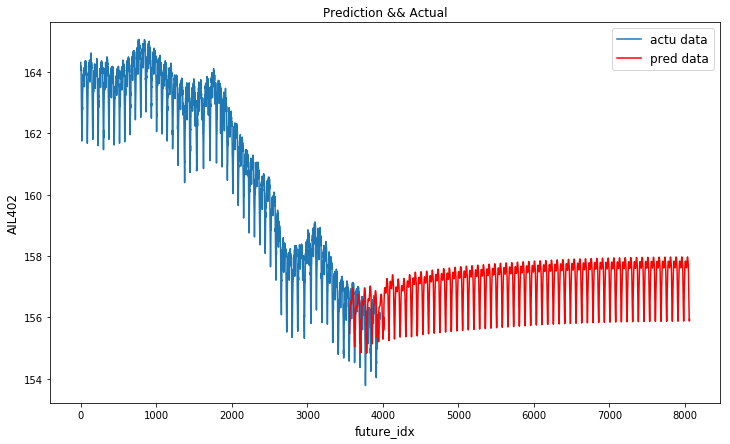

In [21]:
#print(x_train)
i=0
x_total_train=x_train
pred_total_value=np.empty((0,1), float)
output_total_seq_test=np.empty((0,1), float)
while i<60:

    input_seq_test = x_total_train[-input_seq_len:].reshape((1,input_seq_len,1))
    #output_seq_test = y[output_seq_len*i:output_seq_len+output_seq_len*i]#2维0.xxx
    #output_total_seq_test=np.vstack([output_total_seq_test,scaler.inverse_transform(output_seq_test)])#真实总量

    decoder_input_test = np.zeros((1,output_seq_len,1))
    pred1 = model2_bi.predict([input_seq_test,decoder_input_test])#3维0.xxx
    pred_values1 = scaler.inverse_transform(pred1.reshape(-1,1))#2维596.xxx
    pred_total_value=np.vstack([pred_total_value,pred_values1])#预测总量
                          
    #output_seq_test1 = scaler.inverse_transform(output_seq_test)#2维600.xxx  2维0.xxx转2维600.xxx

    x_total_train=np.vstack([x_total_train,pred1.reshape(-1,1)])

    i=i+1
#print(pred_total_value)
output_total_seq_test=np.vstack([scaler.inverse_transform(x_train),pred_total_value])
plt.figure(figsize=(12,7))
a=len(seq.values)
#a=len(scaler.inverse_transform(x_train))
b=len(pred_total_value)
x=np.arange(0,a,1)
x1=np.arange(len(x_train),len(x_train)+b,1)
#plt.plot(x,scaler.inverse_transform(x_train), label = "actu data")
plt.plot(x,seq.values, label = "actu data")
plt.plot(x1,pred_total_value,'r',label="pred data")
plt.title("Prediction && Actual")
plt.ylabel('AIL402', fontsize=12)
plt.xlabel("future_idx", fontsize=12)
plt.legend(loc='upper right', fontsize=12)
#+np.random.uniform(-0.1, 0.2, (len(pred_values1), 1))

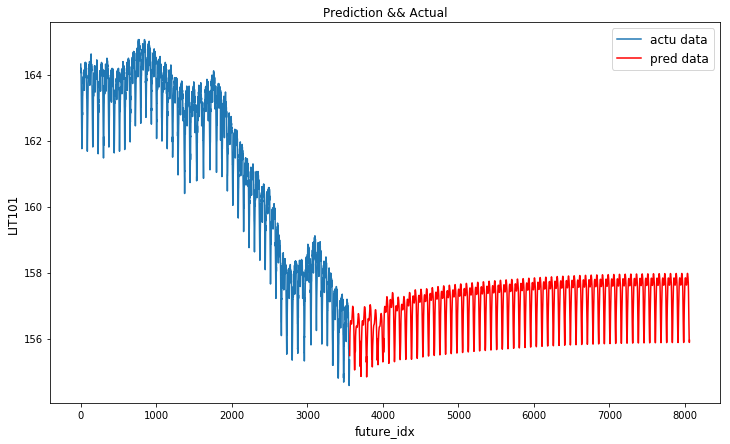

In [22]:
# #print(x_train)
# i=0
# x_total_train=x_train
# pred_total_value=np.empty((0,1), float)
# output_total_seq_test=np.empty((0,1), float)
# while i<60:

#     input_seq_test = x_total_train[-input_seq_len:].reshape((1,input_seq_len,1))
#     #output_seq_test = y[output_seq_len*i:output_seq_len+output_seq_len*i]#2维0.xxx
#     #output_total_seq_test=np.vstack([output_total_seq_test,scaler.inverse_transform(output_seq_test)])#真实总量

#     decoder_input_test = np.zeros((1,output_seq_len,1))
#     pred1 = model2_bi.predict([input_seq_test,decoder_input_test])#3维0.xxx
#     pred_values1 = scaler.inverse_transform(pred1.reshape(-1,1))#2维596.xxx
#     pred_total_value=np.vstack([pred_total_value,pred_values1])#预测总量
                          
#     #output_seq_test1 = scaler.inverse_transform(output_seq_test)#2维600.xxx  2维0.xxx转2维600.xxx

#     x_total_train=np.vstack([x_total_train,pred1.reshape(-1,1)])

#     i=i+1
# #print(pred_total_value)
# output_total_seq_test=np.vstack([scaler.inverse_transform(x_train),pred_total_value])
# plt.figure(figsize=(12,7))
# a=len(scaler.inverse_transform(x_train))
# b=len(pred_total_value)
# x=np.arange(0,a,1)
# x1=np.arange(a,a+b,1)
# plt.plot(x,scaler.inverse_transform(x_train), label = "actu data")
# plt.plot(x1,pred_total_value,'r',label="pred data")
# plt.title("Prediction && Actual")
# plt.ylabel("LIT101", fontsize=12)
# plt.xlabel("future_idx", fontsize=12)
# plt.legend(loc='upper right', fontsize=12)

In [23]:
# actu=scaler.inverse_transform(x_train)
# print(actu)
# print(pred_total_value)
# total_value=np.vstack([actu,pred_total_value])
# print(len(total_value))


[[164.3168]
 [164.1374]
 [164.0605]
 ...
 [155.2166]
 [155.2166]
 [155.3448]]
[[155.48260498]
 [155.72601318]
 [155.9066925 ]
 ...
 [155.88092041]
 [155.89523315]
 [155.94274902]]
8060


In [24]:
# save = pd.DataFrame(total_value)
# save.to_csv('E:/python_code/时间序列预测/训练csv文件/预测数据_AIT402.csv',sep=',')